<a href="https://colab.research.google.com/github/LuisEduardoRB/EDP-II/blob/main/Ecuaci%C3%B3n_de_Onda_M%C3%A9todo_Expl%C3%ADcito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; color:#1f2d3d;">
Método Explícito
</h1>

<h3 style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; font-weight:400; color:#4a6278;">
Solución numérica de la ecuación de onda
</h3>

<hr style="border: 1px solid #d5d8dc; width:70%;">

<p style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; color:#7b8a8b;">
<u>Programa en Python para Ecuaciones Diferenciales Parciales</u>
</p>

***En todo el programa no usamos la librería Sympy debido a que ella se esmpecializa en calculos simbólicos, cosa que no queremos aquí. Aquí nos enfocamos en calculos y en ver números, no matrices bonitas. Es por eso que se tomó la decisión de no usar Sympy, aparte de que así nos evitamos el cambio de formato en los datos con las matrices y arreglos, hacemos todo con Numpy y nos evitamos andar convirtiendo los datos***

## Bloque 1: Importación de librerías y configuración de animación

En este bloque se importan las librerías necesarias para implementar y visualizar el método numérico para la ecuación de onda:

- `numpy as np`: se usa para el manejo de vectores y matrices numéricas, que representarán la malla espacial, los tiempos y la solución numérica $U[n,j]$.  
  - Funciones relevantes: `np.arange`, `np.linspace`, `np.zeros`, `np.sin`, `np.cos`, `np.max`, `np.min`, etc.

- `matplotlib.pyplot as plt`: se utiliza para generar todas las gráficas:
  - Gráfico 1D de $u(x,1)$ (numérica vs exacta).
  - Contornos 2D de $u(x,t)$.
  - Superficie 3D de $u(x,t)$.
  - Configuración de figuras, etiquetas y leyendas.

- `Axes3D` de `mpl_toolkits.mplot3d`: permite crear ejes 3D para la gráfica de superficie de $u(x,t)$.

- `matplotlib.cm as cm`: proporciona mapas de color (por ejemplo, `cm.viridis`) para las gráficas de contorno y superficie, facilitando la visualización de la solución de la EDP.

- `tabulate`: se usa para imprimir en la consola una tabla formateada que compara la solución numérica con la solución exacta.

- `matplotlib.rc`: se utiliza para configurar el comportamiento de `matplotlib`, en este caso:
  - `rc('animation', html='jshtml')` indica que las animaciones se rendericen en formato JavaScript/HTML, adecuado para notebooks.

- `IPython.display.HTML`: sirve para mostrar la animación en la salida del notebook con `HTML(ani.to_jshtml())`.

- `matplotlib.animation as animation`: se usa para crear la animación temporal de la solución de la ecuación de onda mediante `animation.FuncAnimation`.

Este bloque prepara todas las herramientas que se utilizarán para discretizar y visualizar la solución de la ecuación diferencial parcial hiperbólica.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para 3D
from matplotlib import cm
from tabulate import tabulate
from matplotlib import rc
from IPython.display import HTML
import matplotlib.animation as animation # Added this line
rc('animation', html='jshtml')

## Bloque 2: Planteamiento del problema y parámetros de malla

Se considera el problema hiperbólico (ecuación de onda):

$u_{tt} - 4u_{xx} = 0 \quad \text{en } 0 < x < 1,\; t > 0,$

con condiciones de frontera:

$u(0,t) = u(1,t) = 0,$

y condiciones iniciales:

$u(x,0) = \sin(\pi x), \quad u_t(x,0) = 0.$

En el código se definen:

- `h = 0.1`: paso espacial, es decir, la distancia entre nodos en la malla de $x$.
- `k = 0.05`: paso temporal, la separación entre instantes de tiempo discretos.
- `c = 2.0`: velocidad de la onda, dado que la ecuación se puede escribir como $u_{tt} = c^2 u_{xx}$ con $c^2 = 4$.
- `r = c * k / h`: número de Courant (parámetro fundamental de estabilidad en esquemas explícitos para la ecuación de onda).
- `r2 = r**2`: valor $r^2$ precalculado para simplificar la fórmula del esquema explícito.

Se imprime `r` para verificar la condición de estabilidad del esquema explícito (se requiere aproximadamente $r \leq 1$).


In [5]:
# ============================================================
# Problema hiperbólico:
#   u_tt - 4 u_xx = 0  en  0 < x < 1,  0 < t
#   u(0,t) = u(1,t) = 0
#   u(x,0) = sin(pi x),   u_t(x,0) = 0
# Método explícito para la ecuación de onda
# ============================================================

# Parámetros de la malla
h = 0.1              # paso espacial
k = 0.05             # paso temporal
c = 2.0              # velocidad de onda, pues u_tt = c^2 u_xx con c^2 = 4
r = c * k / h        # número de Courant
r2 = r**2

print(f'r = {r:.3f} (debe ser <= 1 para estabilidad)')

r = 1.000 (debe ser <= 1 para estabilidad)


## Bloque 3: Malla espacial

Se construye la discretización del intervalo espacial:

- `x = np.arange(0.0, 1.0 + h, h)`: genera los puntos espaciales $x_j = jh$ para $j = 0, 1, \dots, 10$, cubriendo $[0,1]$ con paso `h = 0.1`.

- `nx = len(x)`: número total de puntos espaciales de la malla.

Estos puntos se utilizarán para aproximar la solución $u(x_j, t_n)$ mediante valores numéricos $U[n,j]$ y para aproximar la derivada segunda espacial $u_{xx}$ por diferencias finitas centradas.

In [6]:
# Malla espacial
x = np.arange(0.0, 1.0 + h, h)   # 0, 0.1, ..., 1
nx = len(x)                      # 11 puntos

## Bloque 4: Discretización temporal

Se definen los parámetros de tiempo:

- `Tfinal = 1.0`: tiempo final de la simulación numérica.
- `nsteps = int(round(Tfinal / k))`: número de pasos de tiempo; con `k = 0.05`, se obtienen 20 pasos.
- `t = np.linspace(0.0, Tfinal, nsteps + 1)`: genera los tiempos discretos $t_n = n k$ para $n = 0, 1, \dots, 20$.

Este vector de tiempos se utiliza para indexar la solución numérica en el tiempo y para comparar la solución numérica con la solución exacta en un tiempo específico (por ejemplo, $t = 1$).

In [7]:
# ============================================================
# Tiempo: resolvemos NUMÉRICAMENTE hasta Tfinal = 1.0
# (para comparar con la tabla en t = 1)
# ============================================================

Tfinal = 1.0                     # tiempo final de la simulación
nsteps = int(round(Tfinal / k))  # 20 pasos con k=0.05
t = np.linspace(0.0, Tfinal, nsteps + 1)


## Bloque 5: Condiciones iniciales y arreglo de la solución

Se definen las funciones para las condiciones iniciales:

- `def u0(x): return np.sin(np.pi * x)`  
  Representa la condición inicial de desplazamiento:
  $u(x,0) = \sin(\pi x).$

- `def ut0(x): return 0.0 * x`  
  Representa la condición inicial de velocidad:
  $u_t(x,0) = 0.$

Luego se crea el arreglo donde se almacenará la solución numérica:

- `U = np.zeros((nsteps + 1, nx))`  
  Aquí `U[n, j]` aproximará $u(x_j, t_n)$.

Inicialización del nivel de tiempo $n = 0$:

- `U[0, :] = u0(x)`: se asigna la condición inicial de desplazamiento en toda la malla espacial.
- `U[0, 0] = 0.0` y `U[0, -1] = 0.0`: se imponen las condiciones de frontera $u(0,0) = 0$ y $u(1,0) = 0$ (Dirichlet homogéneas).

Este bloque fija el estado inicial de la solución de la EDP en la malla discreta.



In [8]:
# ============================================================
# Condiciones iniciales
# ============================================================

def u0(x):
    return np.sin(np.pi * x)

def ut0(x):
    return 0.0 * x   # velocidad inicial nula

# U[n, j] ≈ u(x_j, t_n)
U = np.zeros((nsteps + 1, nx))

# Tiempo n = 0
U[0, :] = u0(x)
U[0, 0] = 0.0
U[0, -1] = 0.0


## Bloque 6: Cálculo del primer nivel de tiempo mediante expansión de Taylor

Para el nivel de tiempo $n = 1$ se usa una aproximación de segundo orden en tiempo basada en la expansión de Taylor:

$u(x,k) \approx u(x,0) + k\,u_t(x,0) + \frac{k^2}{2} u_{tt}(x,0).$

Dado que la ecuación de onda es:

$u_{tt} = c^2 u_{xx},$

se requiere una aproximación de la segunda derivada espacial en $t = 0$:

- `u_xx_0 = (U[0, j+1] - 2*U[0, j] + U[0, j-1]) / h**2`  
  Esta es la fórmula de diferencia centrada de segundo orden para $u_{xx}(x_j, 0)$.

Luego se actualiza:

- `U[1, j] = U[0, j] + k * ut0(x[j]) + 0.5 * (k**2) * (c**2) * u_xx_0`

Aquí se usan:
- `ut0(x[j])` para la velocidad inicial (en este caso cero).
- `c**2 * u_xx_0` para representar $u_{tt}(x_j,0)$.

Finalmente se imponen las condiciones de frontera en $n = 1$:

- `U[1, 0] = 0.0`, `U[1, -1] = 0.0`.

Este bloque construye el segundo nivel de tiempo requerido para poder aplicar el esquema explícito de tres niveles para la ecuación de onda.



In [9]:
# Primer nivel de tiempo (n = 1) usando Taylor:
# u(x, k) ≈ u(x,0) + k u_t(x,0) + (k^2 / 2) u_tt(x,0)
# y u_tt = c^2 u_xx
for j in range(1, nx - 1):
    u_xx_0 = (U[0, j+1] - 2*U[0, j] + U[0, j-1]) / h**2
    U[1, j] = U[0, j] + k * ut0(x[j]) + 0.5 * (k**2) * (c**2) * u_xx_0

# Condiciones de frontera en n = 1
U[1, 0] = 0.0
U[1, -1] = 0.0


## Bloque 7: Esquema explícito de diferencias finitas para $n \ge 1$

Se implementa el esquema explícito estándar para la ecuación de onda 1D:

$\dfrac{U_j^{n+1} - 2U_j^n + U_j^{n-1}}{k^2}
= c^2 \dfrac{U_{j+1}^n - 2U_j^n + U_{j-1}^n}{h^2}.$

Al despejar $U_j^{n+1}$:

$U_j^{n+1}
= 2U_j^n - U_j^{n-1}
+ r^2 \bigl(U_{j+1}^n - 2U_j^n + U_{j-1}^n\bigr),$

donde $r = \dfrac{ck}{h}$.

El código recorre:
- `n` desde 1 hasta `nsteps - 1`.
- `j` desde 1 hasta `nx - 2` (puntos interiores).

En cada iteración:
- Actualiza `U[n+1, j]` usando la fórmula anterior.
- Impone las condiciones de frontera:
  - `U[n+1, 0] = 0.0`, `U[n+1, -1] = 0.0`.

Este bloque es el núcleo del método numérico de diferencias finitas explícitas para la EDP hiperbólica.



In [10]:
# ============================================================
# Esquema explícito para n >= 1
# (u_j^{n+1} - 2u_j^n + u_j^{n-1}) / k^2 =
#     c^2 (u_{j+1}^n - 2u_j^n + u_{j-1}^n) / h^2
# ============================================================

for n in range(1, nsteps):
    for j in range(1, nx - 1):
        U[n+1, j] = (2 * U[n, j] - U[n-1, j] +
                     r2 * (U[n, j+1] - 2*U[n, j] + U[n, j-1]))
    # fronteras
    U[n+1, 0] = 0.0
    U[n+1, -1] = 0.0


## Bloque 8: Definición de la solución exacta

Se define la función:

$u(x,t) = \sin(\pi x)\,\cos(2\pi t),$

mediante:

- `def u_exacta(x, t_val): return np.sin(np.pi * x) * np.cos(2 * np.pi * t_val)`.

Esta función representa la solución analítica del problema de la ecuación de onda con:
- Condiciones de frontera homogéneas en $x = 0,1$.
- Condiciones iniciales:
  - $u(x,0) = \sin(\pi x)$ (coincide con la forma espacial).
  - $u_t(x,0) = 0$ (derivada temporal inicial nula).

La solución exacta se usa para comparar y evaluar el error del método numérico.



In [11]:
# ============================================================
# Solución exacta del problema
# u(x,t) = sin(pi x) cos(2 pi t)
# ============================================================

def u_exacta(x, t_val):
    return np.sin(np.pi * x) * np.cos(2 * np.pi * t_val)


## Bloque 9: Tabla de comparación numérica vs exacta en $t = 1$ y cálculo de errores

Se identifica el índice temporal correspondiente a $t = 1$:

- `k_final = nsteps` y `t_final = t[k_final]`.

Se extraen:
- `vals_num = U[k_final, :]`: solución numérica en $t = 1$.
- `vals_ex = u_exacta(x, t_final)`: solución exacta evaluada en la misma malla espacial.
- `error = np.abs(vals_num - vals_ex)`: error puntual en cada nodo espacial.

Se construye una tabla con:
- $x_j$: nodos espaciales.
- `w_j,20 (num)`: valores numéricos en $t = 1$.
- $u(x_j,1)$ exacta: valores de la solución exacta.
- $|error|$: error absoluto.

La librería `tabulate` formatea esta información en una tabla legible (tipo `grid`).

Luego se calculan medidas globales de error:

- `err_max = np.max(error)`: error máximo (norma infinito discreta).
- `err_L2 = np.sqrt(h * np.sum(error**2))`: aproximación de la norma $L^2$ discreta del error en $t = 1$.

Este bloque permite cuantificar la calidad de la aproximación numérica de la EDP comparando con la solución exacta.



In [12]:
# ============================================================
# TABLA DE COMPARACIÓN en t = 1  (como la tabla 12.6)
# ============================================================

k_final = nsteps        # índice n correspondiente a t = 1
t_final = t[k_final]    # debería ser 1.0

vals_num = U[k_final, :]
vals_ex = u_exacta(x, t_final)
error = np.abs(vals_num - vals_ex)

headers = ["x_j", "w_j,20 (num)", "u(x_j,1) exacta", "|error|"]
table = []
for xj, wn, ue, err in zip(x, vals_num, vals_ex, error):
    table.append([f"{xj:.1f}",
                  f"{wn:.10f}",
                  f"{ue:.10f}",
                  f"{err:.2e}"])

print("\nTabla de comparación en t = 1 (explícito vs exacta)")
print(tabulate(table, headers=headers, tablefmt="grid"))

# Error global en t = 1
err_max = np.max(error)
err_L2 = np.sqrt(h * np.sum(error**2))
print(f"\nError máximo en t = {t_final:.2f}: {err_max:.4e}")
print(f"Error L2 discreto en t = {t_final:.2f}: {err_L2:.4e}")



Tabla de comparación en t = 1 (explícito vs exacta)
+-------+----------------+-------------------+-----------+
|   x_j |   w_j,20 (num) |   u(x_j,1) exacta |   |error| |
+=======+================+===================+===========+
|   0   |       0        |          0        |  0        |
+-------+----------------+-------------------+-----------+
|   0.1 |       0.309017 |          0.309017 |  5.55e-17 |
+-------+----------------+-------------------+-----------+
|   0.2 |       0.587785 |          0.587785 |  0        |
+-------+----------------+-------------------+-----------+
|   0.3 |       0.809017 |          0.809017 |  0        |
+-------+----------------+-------------------+-----------+
|   0.4 |       0.951057 |          0.951057 |  4.44e-16 |
+-------+----------------+-------------------+-----------+
|   0.5 |       1        |          1        |  1.11e-16 |
+-------+----------------+-------------------+-----------+
|   0.6 |       0.951057 |          0.951057 |  1.11e-16 |
+--

## Bloque 10: Gráfica 1D numérica vs exacta en $t = 1$

Se genera una figura en la que se comparan:

- La solución numérica en $t = 1$: `plt.plot(x, vals_num, "o-", label="Numérico explícito (t=1)")`.
- La solución exacta en $t = 1$: `plt.plot(x, vals_ex, "--", label="Exacta (t=1)")`.

Se añaden:
- Etiquetas de ejes (`x`, `u(x,1)`).
- Título con el valor de `t_final`.
- Rejilla y leyenda.

Esta gráfica permite visualizar directamente qué tan cerca está la solución numérica de la solución teórica para la ecuación de onda.



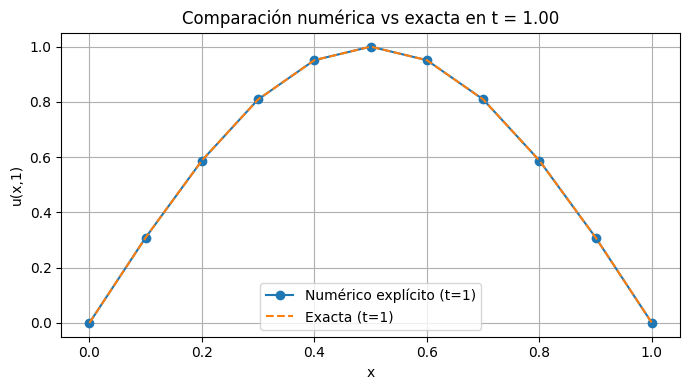

In [13]:
# ============================================================
# Gráfica 1D: comparación numérica vs exacta en t = 1
# (esto sigue igual: la comparación es a t=1)
# ============================================================

plt.figure(figsize=(7, 4))
plt.plot(x, vals_num, "o-", label="Numérico explícito (t=1)")
plt.plot(x, vals_ex, "--", label="Exacta (t=1)")
plt.xlabel("x")
plt.ylabel("u(x,1)")
plt.title(f"Comparación numérica vs exacta en t = {t_final:.2f}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Bloque 11: Preparación de datos para gráficas 2D y 3D (hasta $t = 0.5$)

Se decide visualizar la solución numérica solo hasta $t = 0.5$:

- `t_max_plot = 0.5`.
- `n_plot = int(round(t_max_plot / k))`: índice temporal asociado a $t = 0.5$.
- `t_plot_vec = t[:n_plot + 1]`: vector de tiempos desde 0 hasta 0.5.
- `U_plot = U[:n_plot + 1, :]`: solución numérica restringida a esos tiempos.

Con `np.meshgrid(x, t_plot_vec)` se construyen:

- `X_plot`: matriz con las coordenadas espaciales repetidas por fila.
- `Tmesh_plot`: matriz con los tiempos repetidos por columna.

Esta malla $(X_{\text{plot}}, T_{\text{mesh}})$ se utilizará para representar $u(x,t)$ como función de dos variables.



In [14]:
# ============================================================
# GRÁFICAS 2D y 3D SOLO HASTA t = 0.5
# ============================================================

# Queremos recortar la malla temporal hasta t = 0.5
t_max_plot = 0.5
n_plot = int(round(t_max_plot / k))      # con k=0.05 → n_plot = 10
t_plot_vec = t[:n_plot + 1]             # tiempos 0,0.05,...,0.5
U_plot = U[:n_plot + 1, :]              # correspondientes valores numéricos

# Malla (x, t) para las gráficas
X_plot, Tmesh_plot = np.meshgrid(x, t_plot_vec)


## Bloque 12: Gráfica de contornos 2D de la solución numérica

Se genera un mapa de contornos rellenados:

- `plt.contourf(X_plot, Tmesh_plot, U_plot, levels=25, cmap=cm.viridis)`  
  Representa el valor de $u(x,t)$ mediante colores para $0 \le t \le 0.5$.

Se añade:
- `plt.colorbar(contour)`: barra de color que indica la escala de valores.
- Título que indica que se trata de la solución numérica de la ecuación de onda.
- Etiquetas de ejes: `x` (espacio) y `t` (tiempo).

Esta gráfica muestra de forma clara cómo evoluciona la solución de la EDP hiperbólica en el plano espacio–tiempo.



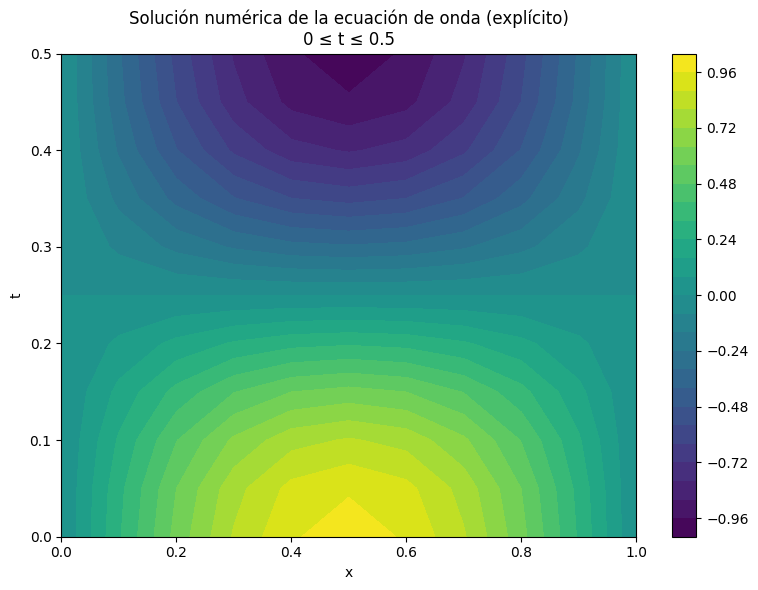

In [15]:
# ------------------------------------------------------------
# Contornos de u(x,t) para 0 <= t <= 0.5
# ------------------------------------------------------------

plt.figure(figsize=(8, 6))
contour = plt.contourf(X_plot, Tmesh_plot, U_plot, levels=25, cmap=cm.viridis)
plt.colorbar(contour)
plt.title("Solución numérica de la ecuación de onda (explícito)\n0 ≤ t ≤ 0.5")
plt.xlabel("x")
plt.ylabel("t")
plt.tight_layout()
plt.show()


## Bloque 13: Gráfica de superficie 3D de la solución numérica

Se construye una figura 3D:

- `ax = fig.add_subplot(111, projection="3d")`: crea un eje 3D.
- `ax.plot_surface(X_plot, Tmesh_plot, U_plot, cmap=cm.viridis, edgecolor="k")`: dibuja la superficie de $u(x,t)$ en el dominio $0 \le x \le 1$, $0 \le t \le 0.5$.

Se añaden:
- Título que indica que se trata de la solución numérica explícita de la ecuación de onda.
- Etiquetas de ejes: `x`, `t`, `u(x,t)$.
- Barra de color para la escala de valores de la solución.

Esta visualización ofrece una perspectiva tridimensional de la solución de la EDP, mostrando simultáneamente su dependencia en el espacio y en el tiempo.



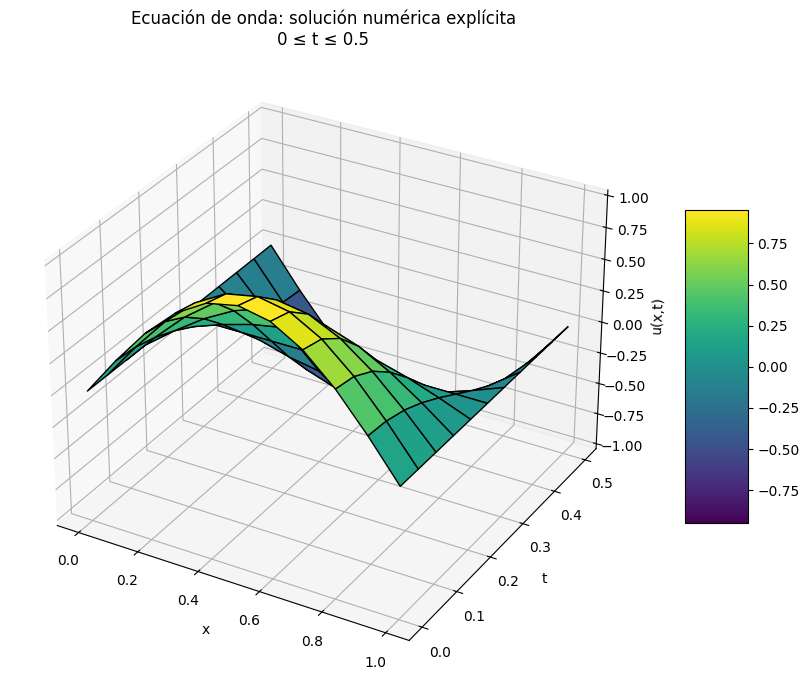

In [16]:
# ------------------------------------------------------------
# Superficie 3D de u(x,t) para 0 <= t <= 0.5
# ------------------------------------------------------------

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X_plot, Tmesh_plot, U_plot, cmap=cm.viridis, edgecolor="k")
ax.set_title("Ecuación de onda: solución numérica explícita\n0 ≤ t ≤ 0.5")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x,t)")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()


## Bloque 14: Animación de la evolución temporal de la onda

Se configura una figura para la animación:

- `fig_anim, ax_anim = plt.subplots(...)`: crea la figura y el eje.
- `linea, = ax_anim.plot(x, U[0, :], '-o')`: inicializa la curva con la solución en $t = 0$.

Se calculan:
- `u_min = np.min(U)` y `u_max = np.max(U)`: valores mínimo y máximo de la solución para fijar adecuadamente el rango vertical (`ylim`) durante toda la animación.

Se definen dos funciones clave:

1. `init()`:
   - Establece los datos iniciales de la línea con `U[0, :]`.
   - Fija el título con el tiempo inicial $t = 0$.
   - Es la función de inicialización requerida por `FuncAnimation`.

2. `actualizar(frame)`:
   - Actualiza la curva `linea` con la solución `U[frame, :]` correspondiente al tiempo `t[frame]`.
   - Actualiza el título para indicar el tiempo actual.
   - Será llamada automáticamente para cada cuadro de la animación.

Luego se define la animación:

- `ani = animation.FuncAnimation(...)`:
  - `frames=len(t)`: se genera un cuadro por cada instante de tiempo de la simulación.
  - `init_func=init`: función de inicialización.
  - `interval=80`: tiempo entre cuadros en milisegundos.
  - `blit=True`: optimiza el redibujado de la animación.

Finalmente, se utiliza:

- `HTML(ani.to_jshtml())`: para incrustar la animación en el notebook en formato HTML/JavaScript.

Este bloque produce una animación que muestra cómo la solución de la ecuación de onda (la EDP hiperbólica) evoluciona en el tiempo respetando las condiciones de frontera fijas en los extremos.

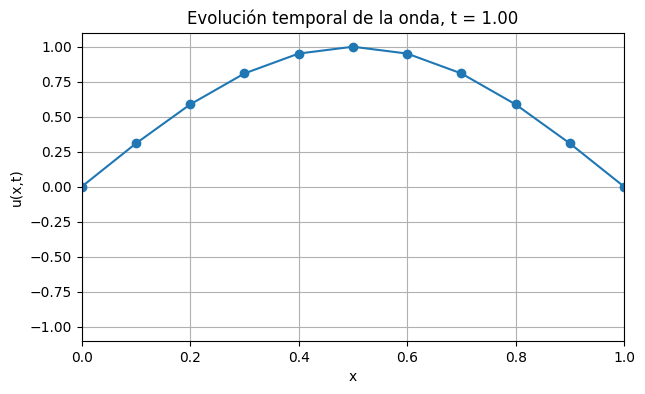

In [17]:
# ============================================================
# Animación de la evolución temporal de la onda
# ============================================================

fig_anim, ax_anim = plt.subplots(figsize=(7, 4))

linea, = ax_anim.plot(x, U[0, :], '-o')
ax_anim.set_xlabel("x")
ax_anim.set_ylabel("u(x,t)")
ax_anim.set_title(f"Evolución temporal de la onda, t = {t[0]:.2f}")

u_min = np.min(U)
u_max = np.max(U)
ax_anim.set_xlim(0.0, 1.0)
ax_anim.set_ylim(1.1 * u_min, 1.1 * u_max)
ax_anim.grid(True)

def init():
    linea.set_data(x, U[0, :])
    ax_anim.set_title(f"Evolución temporal de la onda, t = {t[0]:.2f}")
    return linea,

def actualizar(frame):
    linea.set_data(x, U[frame, :])
    ax_anim.set_title(f"Evolución temporal de la onda, t = {t[frame]:.2f}")
    return linea,

ani = animation.FuncAnimation(
    fig_anim,
    actualizar,
    frames=len(t),
    init_func=init,
    interval=80,
    blit=True
)

HTML(ani.to_jshtml())
